<a href="https://colab.research.google.com/github/samarakoon-ryan/Grovers-Algorithm/blob/real-device-experiment/implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Grover's Algorithm using IBM Qiskit

## Install Dependencies

In [1]:
# pip installs Qiskit
!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
!pip install qiskit-ibm-runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qiskit-community/qiskit-textbook.git to /tmp/pip-req-build-2u0s5qpb
  Running command git clone -q https://github.com/qiskit-community/qiskit-textbook.git /tmp/pip-req-build-2u0s5qpb
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

## 2 Qubit Example

We will be searching for |
w
⟩
 [3]

### Initialize the state

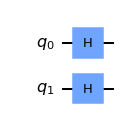

In [4]:
# We prepare a quantum circuit with 2 qubits
n = 2
grovers_circuit = QuantumCircuit(n)

# We then apply an H-gate to each qubit in order for it to get into 
# a superposition state. The default initial state is |0> so 
# H|0> = |+>

def initialize_superposition(qc, qubits):
    """Apply an H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

# The above function is used to initialize our circuit
grovers_circuit = initialize_superposition(grovers_circuit, [0,1])
grovers_circuit.draw(output='mpl')

### Oracle

- Oracle for  |ω⟩ = |11⟩

- This is essentially a controlled Z-gate, so for this example the oracle is simply the controlled Z-gate.
 

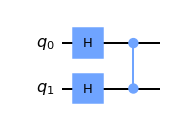

In [5]:
# Apply the Oracle
grovers_circuit.cz(0,1) # Z-gate that joins Qubit 0 and Qubit 1
grovers_circuit.draw(output='mpl')


### Diffuser

- We will apply the diffusion operator to both qubits.
- This includes an H-gate, Z-gate, controlled Z-gate, and another H-gate.

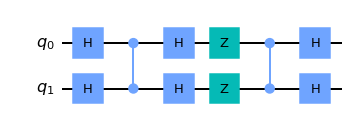

In [6]:
# Diffusion operator
grovers_circuit.h([0,1])
grovers_circuit.z([0,1])
grovers_circuit.cz(0,1)
grovers_circuit.h([0,1])
grovers_circuit.draw(output='mpl')

This is the finished circuit!

## Simulation Experiment

First, we will verify that we have the correct statevector.

In [7]:
sim = Aer.get_backend('aer_simulator')
# we need to make a copy of the circuit with the 'save_statevector'
# instruction to run on the Aer simulator
grovers_circuit_sim = grovers_circuit.copy()
grovers_circuit_sim.save_statevector()
qobj = assemble(grovers_circuit_sim)
result = sim.run(qobj).result()
statevec = result.get_statevector()
from qiskit_textbook.tools import array_to_latex
array_to_latex(statevec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

We then verify the probability of measuring |11⟩ and all other states. It should be 100% for |11⟩ and 0% for all others.



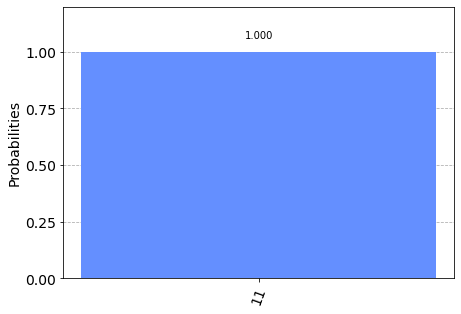

In [8]:
# We measure all the qubits and then use the simulator to get probabilities
grovers_circuit.measure_all()

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(grovers_circuit)
result = aer_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

## Real Device Experiment

In [26]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Save an IBM Quantum account.
IBMQ.save_account(token="****")
provider = IBMQ.load_account()

configrc.store_credentials:WARNING:2022-10-01 00:18:54,564: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-10-01 00:18:54,860: Credentials are already in use. The existing account in the session will be replaced.


In [29]:
# Run the circuit on a real device
backend = least_busy(provider.backends(filters=lambda x: int(x.configuration().n_qubits) >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)
device = backend

least busy backend:  ibmq_belem


In [30]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grovers_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


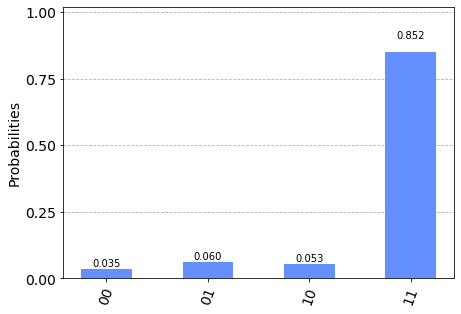

In [31]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grovers_circuit)
plot_histogram(answer)

We confirm that in the majority of the cases the state |11⟩ is measured. The other results are due to errors in the quantum computation.